In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from PIL import Image

Load the data

In [3]:
X_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_train.npy')
X_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_val.npy')
X_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_test.npy')
y_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_train.npy')
y_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_val.npy')
y_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_test.npy')

In [4]:
y_train = np.array(pd.get_dummies(y_train))
y_val = np.array(pd.get_dummies(y_val))
y_test = np.array(pd.get_dummies(y_test))

In [5]:
print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(X_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'y_val shape: {(X_val).shape}\n'
      f'X_val shape: {(y_val).shape}')

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

X_train shape: (4569, 256, 256, 3)
y_train shape: (4569, 4)
X_test shape: (1311, 256, 256, 3)
y_test shape: (1311, 4)
y_val shape: (1143, 256, 256, 3)
X_val shape: (1143, 4)


Data augmentation

In [6]:
train_aug = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
train_aug.fit(X_train)

val_aug = ImageDataGenerator()
val_aug.fit(X_val)

# Custom VGG16

In [7]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base.layers:
    layer.trainable = False
    print(layer.name, layer.trainable)

58889256/58889256 [==============================] - 2s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [8]:
x = layers.GlobalMaxPooling2D()(base.output)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.4)(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predict = layers.Dense(4, activation='softmax')(x)
model = Model(inputs=base.input, outputs=predict)

optim = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, amsgrad = True)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

Feature extraction

In [9]:
batch = 64
epoch = 5

start = time.time()
history = model.fit(train_aug.flow(X_train, y_train, batch_size = batch),
                    validation_data = val_aug.flow((X_val, y_val)),
                    epochs = epoch,
                    verbose = 1,
                    steps_per_epoch = (X_train.shape[0] // batch),
                    validation_steps = (X_val.shape[0] // batch),
                    )

end = time.time()
runtime = end - start
print("Feature extraction time elapsed: ", runtime, "s")

Epoch 1/5
71/71 [==============================] - 72s 869ms/step - loss: 1.9566 - accuracy: 0.2868 - val_loss: 1.5277 - val_accuracy: 0.2702
Epoch 2/5
71/71 [==============================] - 61s 852ms/step - loss: 1.6397 - accuracy: 0.3589 - val_loss: 1.2143 - val_accuracy: 0.4540
Epoch 3/5
71/71 [==============================] - 61s 852ms/step - loss: 1.4568 - accuracy: 0.4231 - val_loss: 1.0313 - val_accuracy: 0.5790
Epoch 4/5
71/71 [==============================] - 61s 856ms/step - loss: 1.3362 - accuracy: 0.4655 - val_loss: 0.8809 - val_accuracy: 0.6875
Epoch 5/5
71/71 [==============================] - 61s 851ms/step - loss: 1.2371 - accuracy: 0.4963 - val_loss: 0.7769 - val_accuracy: 0.7224
Feature extraction time elapsed:  317.41209959983826 s


Retraining

In [10]:
for layer in base.layers:
    layer.trainable = True

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5,
                                            min_lr=0.000001, cooldown=2)

In [12]:
optim = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, amsgrad = True)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
batch = 64
epoch = 10

start = time.time()
history = model.fit(train_aug.flow(X_train, y_train, batch_size = batch),
                    validation_data = (X_val, y_val),
                    epochs = epoch,
                    verbose = 1,
                    steps_per_epoch = (X_train.shape[0] // batch),
                    validation_steps = (X_val.shape[0] // batch),
                    callbacks = [learning_rate_reduction]
                    )

end = time.time()
runtime = end - start
print("Time elapsed: ", runtime, "s")

Epoch 1/10
71/71 [==============================] - 88s 1s/step - loss: 1.2981 - accuracy: 0.4706 - val_loss: 4.4439 - val_accuracy: 0.2686 - lr: 1.0000e-04
Epoch 2/10
71/71 [==============================] - 63s 883ms/step - loss: 0.8988 - accuracy: 0.6317 - val_loss: 1.3989 - val_accuracy: 0.5993 - lr: 1.0000e-04
Epoch 3/10
71/71 [==============================] - 63s 891ms/step - loss: 0.6589 - accuracy: 0.7521 - val_loss: 1.0093 - val_accuracy: 0.7454 - lr: 1.0000e-04
Epoch 4/10
71/71 [==============================] - 62s 872ms/step - loss: 0.4934 - accuracy: 0.8313 - val_loss: 0.4153 - val_accuracy: 0.8530 - lr: 1.0000e-04
Epoch 5/10
71/71 [==============================] - 62s 873ms/step - loss: 0.3969 - accuracy: 0.8701 - val_loss: 0.2209 - val_accuracy: 0.9248 - lr: 1.0000e-04
Epoch 6/10
71/71 [==============================] - 63s 884ms/step - loss: 0.3252 - accuracy: 0.8937 - val_loss: 0.6315 - val_accuracy: 0.8268 - lr: 1.0000e-04
Epoch 7/10
71/71 [=========================

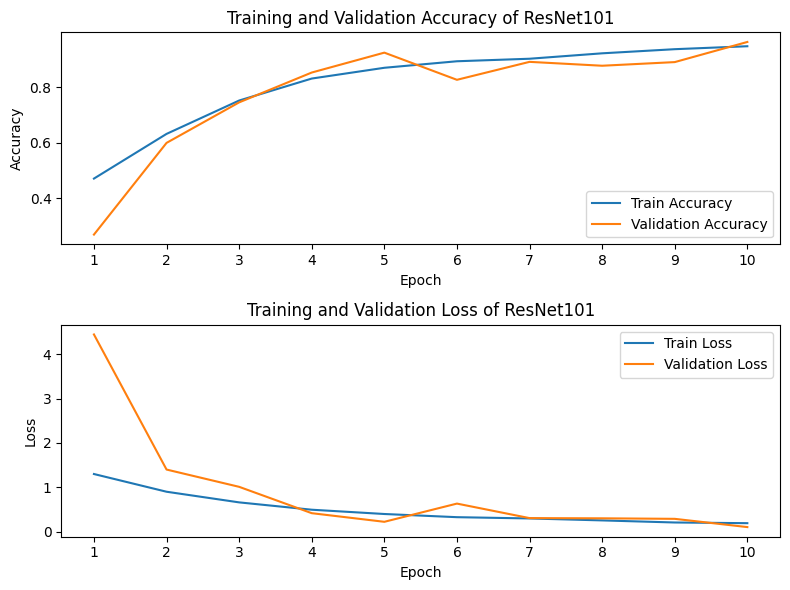

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
epochs_range = range(1,11)
# Accuracy subplot
ax1.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title(f'Training and Validation Accuracy of ResNet101')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc = 'lower right')
ax1.set_xticks(list(epochs_range))

# Loss subplot
ax2.plot(epochs_range, history.history['loss'], label='Train Loss')
ax2.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
ax2.set_title(f'Training and Validation Loss of ResNet101')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc = 'upper right')
ax2.set_xticks(list(epochs_range))

plt.tight_layout()
plt.show()

In [15]:
model.save('/content/drive/MyDrive/MLMed/VGG16.keras')

In [16]:
y_true = np.argmax(y_test, axis = 1)
y_pred = np.argmax(model.predict(X_test), axis = 1)

print(classification_report(y_true, y_pred))

41/41 [==============================] - 4s 106ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       300
           1       0.91      0.98      0.94       306
           2       0.99      0.97      0.98       405
           3       0.99      0.97      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [17]:
dict = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
classname = [dict[label] for label in np.unique(y_pred)]
print(classname)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


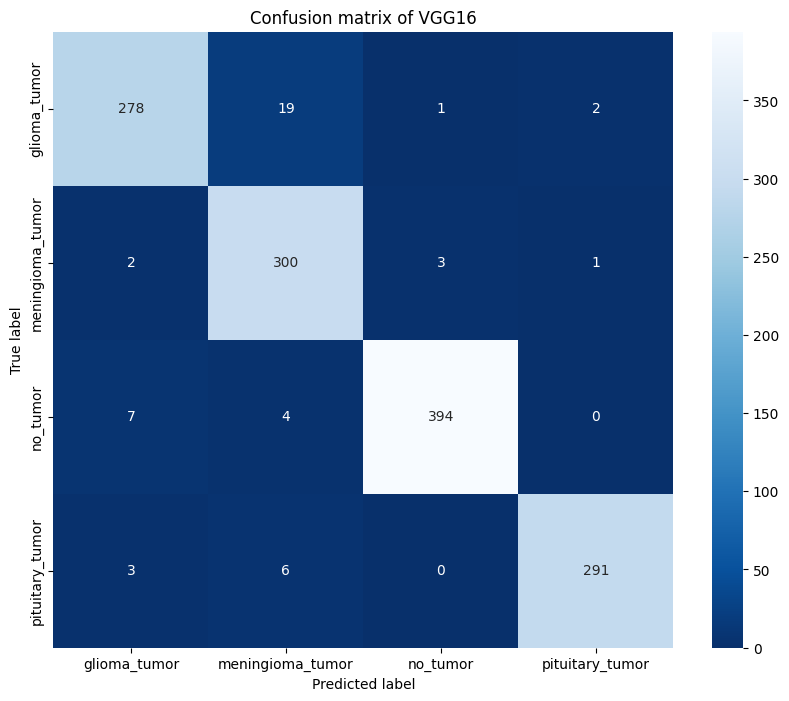

In [18]:
plt.figure(figsize = (10, 8))
hm = sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = 'd', cmap = 'Blues_r'
, xticklabels = classname, yticklabels = classname)
plt.title('Confusion matrix of VGG16')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [19]:
index = np.random.choice(len(X_test), size=100, replace=False)

fig, axs = plt.subplots(20, 5, figsize=(25, 150))

axs = axs.flatten()

for i, idx in enumerate(index):
    axs[i].imshow(X_test[idx])
    label = dict[y_pred[idx]]
    label_true = dict[y_true[idx]]
    axs[i].set_xlabel('pred: ' + label, fontsize=22, color='red')
    axs[i].set_ylabel('true: ' + label_true, fontsize=22, color='red')
    axs[i].set_xticklabels(axs[i].get_xticks(), rotation=90)
    axs[i].axis('on')

plt.tight_layout()

plt.show()